# Big project activity

## Optimal charging station location

### 1.Introduction

Consider a long linear cycle path as Vento, or the Danube cycle path. The cycle path usually runs along the banks of a river with scarce tourist interest. However, from the main course of the cycle path, it is possible to reach places of tourist interest in making small detours.  

The rapid growth of e-bike ridership is proposing the problem of deploying a suitable charging infrastructure. The charging stations should be placed in strategic positions so as to guarantee a coverage of the whole cycle path. However, since the charging operations require a non-negligible time, the charging station should be positioned in places where alternative activities could be carried out, as restaurants, museums, swimming pool, or other amenities. Moreover, the presence of a charging station could also induce e-cyclists to discover new places and generate positive externalities.



### 2.Decision problem
We can represent the cycle path as a graph where the set of nodes $H = \{1,\ldots, n\}$ corresponds to the tourist sites that may host a charging station.
In addition, we are given the distances between touristic sites ($d_{ij},$ with $ i,j =1,\ldots,n$). Let $c_i$ be the cost of installing a charging station in site $i, i=1\ldots, n$.


The problem is, given a budget $b$, determine the subset of sites $S\subseteq H$ where to install the charging stations so that the total cost is not higher than $b$ and the maximum distance between consecutive charging stations is minimized.
Consider that the cyclist has to visit all the touristic destinations in a consecutive way.



### 3.Problem characteristics
There are 2 csv files that contain the information of the cycle way, they are essential to build the equivalent graph:


*    in the "nodes.csv" file, there are all the destinations that the cyclist can reach, with their spatial coordinates and the value of installation costs related to that destination. Consider that the "tourist-dest-id" is not the graph node number, but it is a unique id to identify the destination.
*   in the "OD.csv" you can find all the arcs between two different nodes, keep attention that the condition of visiting consecutive touristic destination must be respected.

The set of nodes $N$ is defined by $\{0,1,\ldots,n, n+1\}$.  The Arcs $A$ correspond to the portion of cycle path between two consecutive charging stations. We assume that potentially e-riders will visit all sites along the way, making the suitable deviations and going back to the main path at the initial point of the detour.
The cost associated with each arc $(i,j)$ is given by $c_j$, thus the cost of installing a charging station in $j$. These costs are defined for all arcs in $A$, while they are set to 0 for all the arcs that arrive in the last node.
The path starts in node $s = 0$ and ends in node $t = n+1$, these two nodes are connected to the nearest touristic site with an arc of null length.

### 4.Example of a linear path with deviation
![picture](https://drive.google.com/uc?export=view&id=1w16bHtbu0FGGL-UntxeqxD7244D3eHbJ)

### 5.Requirements
The requirements of the problem are:


*   the maximum running time of the algorithm must be 5 minutes, so set the proper timer
*   create the equivalent graph and display it on a xy-plot
*   find the solution for the basic scenario, with a mip model, displaying the solution with a xy-plot, the budget constraint is $b = 10000\ € $.
*   Find the optimal solution for 5 different values of budget in the range $[10000, 100000]$. Select the values of the budget so as to have different charger locations.

  You have to motivate your choice and the solution you get. They can also be not common solution if they are well motivated. To support your decision and explanations, you can print plots or tables. You can also compare different scenarios.


   
If you have some doubts related to the parametric analysis, prof. Cubillos uploaded a notebook with the solution on WeBeeP and you can have a look there.

### Insert student name and student ID

student1:

ID1:

student2:

ID2:

student3

ID3:



In [3]:
#install libraries
!pip install mip
!pip install --upgrade cffi==1.15.0

In [2]:
#import libraries
import importlib
import cffi

importlib.reload(cffi)
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import time
import random

In [4]:
# set the budget
budget: int = 10_000
# budget = random.randint(10000, 100000)
print(f"Budget: {budget:,.2f} €")

Budget: 10,000.00 €


# Import of the data

In [5]:
# Load nodes data from CSV
nodes_data: pd.DataFrame = pd.read_csv('nodes.csv')

# Display information about candidate touristic sites and nodes
num_nodes: int = len(nodes_data) + 2
print(f"Number of candidate touristic sites: {len(nodes_data)}")
print(f"Number of Nodes (including source and sink): {num_nodes}")

# Load OD data from CSV and map node IDs
od_data: pd.DataFrame = pd.read_csv('OD.csv')
node_id_mapping: dict[int, int] = {node_id: i for i, node_id in enumerate(nodes_data['tourist_dest_id'])}
od_data[['origin_id', 'destination_id']] = od_data[['origin_id', 'destination_id']].apply(
    lambda x: x.map(node_id_mapping))

# Map node IDs in nodes_data
nodes_data['tourist_dest_id'] = nodes_data['tourist_dest_id'].map(node_id_mapping)

# Display the number of arcs and the node ID mapping
print(f"Number of arcs: {len(od_data)}")
print(f"Node ID Mapping: {node_id_mapping}")

Number of candidate touristic sites: 44
Number of Nodes (including source and sink): 46
Number of arcs: 1936
Node ID Mapping: {0: 0, 17: 1, 18: 2, 20: 3, 21: 4, 23: 5, 24: 6, 25: 7, 29: 8, 30: 9, 31: 10, 32: 11, 33: 12, 35: 13, 36: 14, 38: 15, 39: 16, 40: 17, 41: 18, 48: 19, 52: 20, 53: 21, 54: 22, 57: 23, 58: 24, 60: 25, 61: 26, 62: 27, 63: 28, 64: 29, 66: 30, 67: 31, 68: 32, 69: 33, 77: 34, 82: 35, 83: 36, 84: 37, 85: 38, 86: 39, 87: 40, 88: 41, 89: 42, 90: 43}


# Print of the locations as markers in a map

In [6]:
import folium
from branca.element import Figure


def create_folium_map(candidate_sites_coordinates: pd.DataFrame, center: list[float]) -> folium.Map:
    """
    Creates a Folium map with CircleMarkers for candidate sites.

    Parameters:
    - candidate_sites_coordinates (pd.DataFrame): DataFrame containing candidate sites data with 'y (latitude)', 'x (longitude)',
      'Comune', 'Piazza', and 'tourist_dest_id'.
    - center (List[float]): List representing the center location of the map [latitude, longitude].

    Returns:
    - folium.Map: Folium map with CircleMarkers for candidate sites.
    """
    # Initialize the map
    map = folium.Map(location=center, zoom_start=10)

    # Add CircleMarkers for each row in candidate_sites_coordinates
    for _, row in candidate_sites_coordinates.iterrows():
        popup_text = f"{row['Comune']} - {row['Piazza']}" if pd.notna(row['Piazza']) else f"{row['Comune']}"

        folium.CircleMarker(
            location=[row['y (latitude)'], row['x (longitude)']],
            radius=5,
            color='blue',
            fill=True,
            fill_color='blue',
            fill_opacity=0.7,
            popup=popup_text,
            tooltip=str(row['tourist_dest_id'])
        ).add_to(map)

    return map


# Center location
map_center: list[float] = [44.92803444, 10.52108953]

# Create Folium map with the specified center
nodes_map: folium.Map = create_folium_map(candidate_sites_coordinates=nodes_data, center=map_center)

# Create a Figure and add the Folium map to it
fig: Figure = Figure(width=1000, height=700)
fig.add_child(nodes_map)

# Display the Figure
fig

# Utility Functions

In [7]:
def find_first_node(nodes_data: pd.DataFrame) -> int:
    """
    Finds the first node based on the lowest value of longitude.

    Parameters:
    - nodes_data (pd.DataFrame): DataFrame containing node data with 'tourist_dest_id', 'x (longitude)', 'y (latitude)', etc.

    Returns:
    - int: The tourist destination ID of the node with the lowest longitude.
    """
    min_longitude_row = nodes_data.loc[nodes_data['x (longitude)'].idxmin()]
    return min_longitude_row['tourist_dest_id']


def find_last_node(nodes_data: pd.DataFrame) -> int:
    """
    Finds the last node based on the highest value of longitude.

    Parameters:
    - nodes_data (pd.DataFrame): DataFrame containing node data with 'tourist_dest_id', 'x (longitude)', 'y (latitude)', etc.

    Returns:
    - int: The tourist destination ID of the node with the highest longitude.
    """
    max_longitude_row = nodes_data.loc[nodes_data['x (longitude)'].idxmax()]
    return max_longitude_row['tourist_dest_id']


# Function to calculate the distance between two nodes
def nodes_distance(node1: int, node2: int, ordered_path, distance_matrix) -> float:
    """
    Calculates the distance between two nodes.

    Parameters:
    - node1 (int): The ID of the first node.
    - node2 (int): The ID of the second node.

    Returns:
    - float: The distance between the two nodes.
    """
    index1 = ordered_path.index(node1)
    index2 = ordered_path.index(node2)
    total_distance = 0
    for i in range(index1, index2):
        total_distance += distance_matrix[ordered_path[i], ordered_path[i+1]]
    return total_distance

# Function to get distance between two nodes from the distance matrix
def get_distance(node1, node2, distance_matrix):
    return distance_matrix[node1, node2]


In [8]:
#set the timer
# Starting time
start_time = time.time()
#TO DO

## TSP

In [22]:
import mip

# Define a function to add a constraint to exclude the current solution
def exclude_current_solution(m, x, current_path):
    # Add a constraint that at least one edge in the current path must be different
    m += mip.xsum(1 - x[i][j] if (i, j) in current_path else x[i][j] for i in range(n) for j in range(n)) >= 1


n = len(nodes_data)
distance_matrix = np.zeros((n, n))

od_data['distance [m]'].fillna(0, inplace=True)
od_data[['origin_id', 'destination_id']] = od_data[['origin_id', 'destination_id']].astype(int)

for _, row in od_data.iterrows():
    i, j = int(row['origin_id']), int(row['destination_id'])
    distance_matrix[i][j] = row['distance [m]']

# Create model
m = mip.Model()

# define the variables
x = [[m.add_var(var_type=mip.BINARY) for j in range(n)] for i in range(n)]

print(f"Number y (arc ij is selected or not) of variables: {len(x)}")

#  define the constraints
first_node = find_first_node(nodes_data)
last_node = find_last_node(nodes_data)


for i in range(n):
    m += x[i][i] == 0

    outgoing_arcs = mip.xsum(x[i][j] for j in range(n) if i != j)
    incoming_arcs = mip.xsum(x[j][i] for j in range(n) if i != j)

    m += outgoing_arcs == 0 if i == last_node else outgoing_arcs == 1
    m += incoming_arcs == 0 if i == first_node else incoming_arcs == 1

# Sub-tour elimination
u = [m.add_var() for i in range(n)]
for i in range(1, n):
    for j in range(1, n):
        if i != j:
            m += u[i] - u[j] + (n - 1) * x[i][j] <= n - 2

# optimize objective function
m.objective = mip.minimize(mip.xsum(distance_matrix[i][j] * x[i][j] for i in range(n) for j in range(n)))

m.optimize()



# Extract the solution path
path = [(i, j) for i in range(n) for j in range(n) if x[i][j].x > 0.5]

# Display the solution path
print("Optimal path:", path)


# Extract the ordered path
current_node = 0
ordered_path = [current_node]

while current_node != 20:
    current_node = next(j for j in range(n) if x[current_node][j].x >= 0.99)
    ordered_path.append(current_node)

# Print the ordered path
print("Ordered path from 0 to 20:", ordered_path)

# Calculate total distance
total_distance = nodes_distance(0, 20, ordered_path, distance_matrix)
print("Total distance from start to finish:", total_distance)



Number y (arc ij is selected or not) of variables: 44
Optimal path: [(0, 43), (1, 2), (2, 3), (3, 4), (4, 5), (5, 34), (6, 7), (7, 8), (8, 9), (9, 10), (10, 11), (11, 12), (12, 13), (13, 14), (14, 15), (15, 16), (16, 17), (17, 18), (18, 33), (19, 24), (21, 20), (22, 21), (23, 22), (24, 23), (25, 19), (26, 27), (27, 25), (28, 26), (29, 28), (30, 29), (31, 30), (32, 31), (33, 32), (34, 6), (35, 36), (36, 37), (37, 1), (38, 39), (39, 35), (40, 38), (41, 40), (42, 41), (43, 42)]
Ordered path from 0 to 20: [0, 43, 42, 41, 40, 38, 39, 35, 36, 37, 1, 2, 3, 4, 5, 34, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 33, 32, 31, 30, 29, 28, 26, 27, 25, 19, 24, 23, 22, 21, 20]
Total distance from start to finish: 238507.22819670002


# Real graph

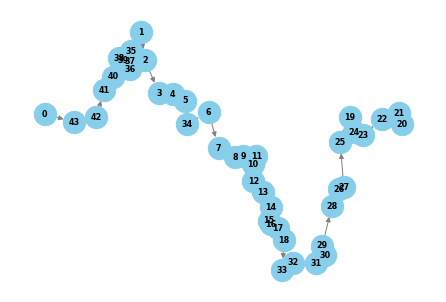

In [23]:
G = nx.DiGraph()

# Add nodes
G.add_nodes_from(nodes_data.apply(lambda row: (
    row["tourist_dest_id"],
    {"pos": (row["x (longitude)"], row["y (latitude)"]), "label": f"{row['Comune']} - {row['Piazza']}"}
), axis=1).tolist())



# Add edges for the optimal path
G.add_edges_from([(origin, destination, {"distance": distance_matrix[origin][destination]}) for origin, destination in path])

# plt.figure(figsize=(15, 15))

# Draw the graph
pos = nx.get_node_attributes(G, "pos")
nx.draw(G, pos, with_labels=True, node_size=500, font_size=8, font_color="black", font_weight="bold",
        node_color="skyblue", edge_color="gray", arrowsize=10)

plt.show()

# Equivalent Graph

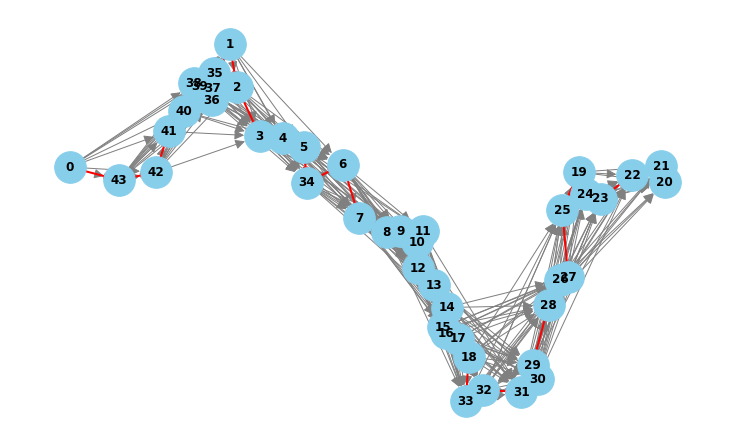

In [24]:
max_distance = 50_000  # 50,000 meters
valid_arcs_dict = {}

for i, start_node in enumerate(ordered_path):
    accumulated_distance = 0
    for next_node in ordered_path[i + 1:]:
        distance = nodes_distance(start_node, next_node, ordered_path, distance_matrix)
        if(distance <= max_distance):
            if not G.has_edge(start_node, next_node):
                G.add_edge(start_node, next_node, distance=distance)
                valid_arcs_dict[(start_node, next_node)] = distance
        else: break


# Create a list of edges for the original path
original_path_edges = [(ordered_path[i], ordered_path[i + 1]) for i in range(len(ordered_path) - 1)]

# Visualization
plt.figure(figsize=(10, 6))
# Draw the graph with all connections
nx.draw(G, pos, with_labels=True, node_size=1000, font_size=12, font_color="black", font_weight="bold",
        node_color="skyblue", edge_color="gray", arrowsize=20)

# Highlight the original path in red
nx.draw_networkx_edges(G, pos, edgelist=original_path_edges, edge_color='red', width=2)

plt.show()

# Do we need to maintain this part?

In [25]:
# Create a 2D array for faster distance lookups
max_id = max(od_data['origin_id'].max(), od_data['destination_id'].max())

print(valid_arcs_dict)
# Create model
m = mip.Model()

# define the variables
# x_i variable for selection of nodes
x = [m.add_var(var_type=mip.BINARY, name=f"x{ordered_path[i]}___{i}") for i in range(n)]
print(f"num x: {len(x)}")

# y_ij variable if we have charging station at point i and at point j
print(ordered_path)


y = [[m.add_var(var_type=mip.BINARY, name=f"y{i}_{j}") for j in range(n)] for i in range(n)]
print(f"num y: {len(y)}")
y_dummy = [[[m.add_var(var_type=mip.BINARY, name=f"y_dummy{l}_{i}_{j}") for j in range(n)] for i in range(n)] for l in range(4)]
print(f"num dummy: {len(y_dummy)}")

#  define the constraints
# 2 constraints that we need put or between them:
# we need 2 dummy which can be anded
# x_i + x_j = 2 iff y_ij = 1
# (x_i + x_j = 2 -> y_ij = 1) and (y_ij = 1 -> x_i + x_j = 2)
# (not(x_i + x_j = 2) or y_ij = 1) and (not(y_ij = 1) or x_i + x_j = 2)
# Budget Constraint
m += mip.xsum(nodes_data.loc[ordered_path[i], 'Cost_of_installation [euro]'] * x[i] for i in range(n)) <= 45000 + nodes_data.loc[first_node, 'Cost_of_installation [euro]'] + nodes_data.loc[last_node, 'Cost_of_installation [euro]']
# Linking constraint
m += x[0] == 1
m += x[-1] == 1
for i in range(n):
    for j in range(n):
        if i != j:
            m += x[i] + x[j] <= 1 + 3 * y_dummy[0][i][j]
            m += y[i][j] - 1 + 3*y_dummy[1][i][j]>= 0
            m += x[i] + x[j] + 3 * y_dummy[2][i][j] >= 2
            m += y[i][j] <= 3 * y_dummy[3][i][j]

            m += y_dummy[0][i][j] + y_dummy[1][i][j] <= 1
            m += y_dummy[2][i][j] + y_dummy[3][i][j] <= 1
            #(Np or q) and (p or Nq)
            #Np or Nq or q or p

# Dummy Variable constraint
z = m.add_var(lb=0.0, var_type=mip.CONTINUOUS, name='max_distance')
# Now, add a constraint to ensure that z is greater than or equal to each d_ij * y_ij
for i in range(n):  # Assuming n is the number of tourist sites
    for j in range(i+1, n):
        m += valid_arcs_dict.get((ordered_path[i], ordered_path[j]), 0) * y[i][j] <= z

    m += mip.xsum(x[l] for l in range(i+1, n) if (ordered_path[i], ordered_path[l]) in valid_arcs_dict) >= 1


# Flow Conservation Constraints
# Flow Conservation Constraints
b = {i: 0 for i in range(n)}
b[first_node] = 1       # Start node (s)
b[last_node] = -1  # Final node (t)

#for i in ordered_path:
#     m += mip.xsum(y[i,j] for j in ordered_path if (i,j) in valid_arcs) -
#                  mip.xsum(y[j,i] for j in ordered_path if (j,i) in valid_arcs) ==
#                  b[i])


# TO DO


# optimize objective function
m.objective = mip.minimize(z)

# TO DO


m.optimize()

{(0, 42): 29832.45227, (0, 41): 34130.609288, (0, 40): 39610.193432, (0, 38): 43246.561147, (0, 39): 44815.590338, (0, 35): 49574.269353, (43, 41): 18119.419498, (43, 40): 23599.003642, (43, 38): 27235.371357, (43, 39): 28804.400548, (43, 35): 33563.079563, (43, 36): 35805.933658, (43, 37): 36795.4581417, (43, 1): 42846.9603267, (43, 2): 49871.7452367, (42, 40): 9777.741162, (42, 38): 13414.108877, (42, 39): 14983.138068, (42, 35): 19741.817083, (42, 36): 21984.671178, (42, 37): 22974.1956617, (42, 1): 29025.6978467, (42, 2): 36050.4827567, (42, 3): 48238.99729670001, (41, 38): 9115.951859, (41, 39): 10684.98105, (41, 35): 15443.660065, (41, 36): 17686.51416, (41, 37): 18676.038643699998, (41, 1): 24727.5408287, (41, 2): 31752.325738699998, (41, 3): 43940.840278699994, (40, 39): 5205.396906, (40, 35): 9964.075921, (40, 36): 12206.930016, (40, 37): 13196.454499700001, (40, 1): 19247.956684700002, (40, 2): 26272.741594700004, (40, 3): 38461.2561347, (40, 4): 48022.2692077, (38, 35): 6327

<OptimizationStatus.OPTIMAL: 0>

In [26]:
for i in range(len(m.vars)):
   if m.vars[i].x and "dummy" not in str(m.vars[i]):
      print(m.vars[i], end=", ")
print()
print(m.objective_value)

x0___0, x42___2, x1___10, x4___13, x8___18, x14___24, x31___31, x25___37, x20___43, y0_2, y0_10, y0_13, y0_18, y0_24, y0_31, y0_37, y0_43, y2_0, y2_10, y2_13, y2_18, y2_24, y2_31, y2_37, y2_43, y10_0, y10_2, y10_13, y10_18, y10_24, y10_31, y10_37, y10_43, y13_0, y13_2, y13_10, y13_18, y13_24, y13_31, y13_37, y13_43, y18_0, y18_2, y18_10, y18_13, y18_24, y18_31, y18_37, y18_43, y24_0, y24_2, y24_10, y24_13, y24_18, y24_31, y24_37, y24_43, y31_0, y31_2, y31_10, y31_13, y31_18, y31_24, y31_37, y31_43, y37_0, y37_2, y37_10, y37_13, y37_18, y37_24, y37_31, y37_43, y43_0, y43_2, y43_10, y43_13, y43_18, y43_24, y43_31, y43_37, max_distance, 
33385.222598


# This needs to be maintained?

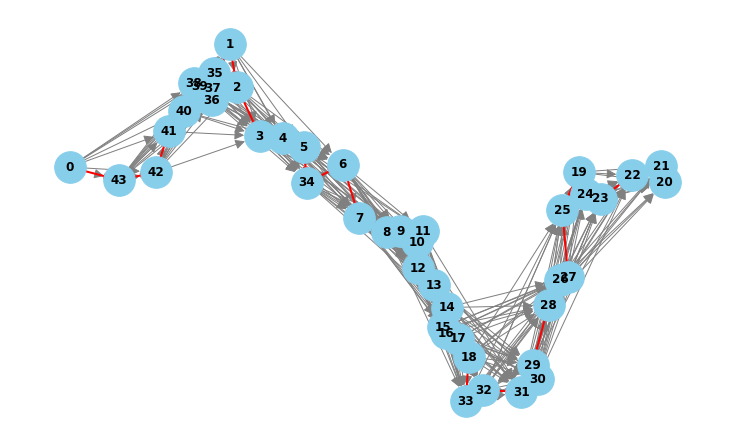

In [27]:
max_distance = 50_000  # 50,000 meters
valid_arcs_dict = {}

for i, start_node in enumerate(ordered_path):
    accumulated_distance = 0
    for next_node in ordered_path[i + 1:]:
        distance = nodes_distance(start_node, next_node, ordered_path, distance_matrix)
        if(distance <= max_distance):
            if not G.has_edge(start_node, next_node):
                G.add_edge(start_node, next_node, distance=distance)
                valid_arcs_dict[(start_node, next_node)] = distance
        else: break

# Create a list of edges for the original path
original_path_edges = [(ordered_path[i], ordered_path[i + 1]) for i in range(len(ordered_path) - 1)]

# Visualization
plt.figure(figsize=(10, 6))
# Draw the graph with all connections
nx.draw(G, pos, with_labels=True, node_size=1000, font_size=12, font_color="black", font_weight="bold",
        node_color="skyblue", edge_color="gray", arrowsize=20)

# Highlight the original path in red
nx.draw_networkx_edges(G, pos, edgelist=original_path_edges, edge_color='red', width=2)

plt.show()

# Optimization (solution finding)

In [28]:
import mip

max_distance = 50_000

def find_valid_arcs(ordered_path, distance_matrix, max_distance):
    valid_arcs = {}

    for i, start_node in enumerate(ordered_path):
        for next_node in ordered_path[i + 1:]:
            distance = nodes_distance(start_node, next_node, ordered_path, distance_matrix)
            if(distance >= 16000 and distance <= 16100):
                print(start_node, next_node, distance)
            if(distance <= max_distance):
                valid_arcs[(start_node, next_node)] = distance
            else: break
    return valid_arcs

valid_arcs = find_valid_arcs(ordered_path, distance_matrix, max_distance)
print(len(nodes_data))
# valid_arcs[-1, 0] = 0
# valid_arcs[20, 4]


# Create model
m = mip.Model()

# define the variables
# x_i variable for selection of nodes
# x = [m.add_var(var_type=mip.BINARY, name=f"x_{i}") for i in range(n)]
# print(f"number of x: {len(x)}")
# y_ij variable if we have charging station at point i and at point j
y = {(i, j): m.add_var(var_type=mip.BINARY, name=f"y{ordered_path[i]}_{ordered_path[j]}___{i}_{j}") for (i, j) in valid_arcs.keys()}
print(f"number of y: {len(y)}")


#  define the constraints
# 1. Budget Constraint
budget = 28_000 + nodes_data.loc[first_node, 'Cost_of_installation [euro]'] + nodes_data.loc[last_node, 'Cost_of_installation [euro]']
# budget = 10_000
print(budget)
m += mip.xsum(nodes_data.loc[i, 'Cost_of_installation [euro]'] * y[i, j] for (i, j) in valid_arcs.keys()) <= budget

# m += mip.xsum(nodes_data.loc[i, 'Cost_of_installation [euro]'] * x[i] for i in nodes_data.index) <= budget

# Linking constraint
# for i in nodes_data.index:
#   for j in nodes_data.index:
#       if (i, j) in valid_arcs.keys():
#         # print("Linking Constraint:", i, j, x[i].name, x[j].name, y[i, j].name)
#         m += y[i, j] <= x[i]
#         m += y[i, j] <= x[j]
#         m += x[i] + x[j] - 1 <= y[i, j]

# Dummy Variable constraint
z = m.add_var(lb=0.0, var_type=mip.CONTINUOUS, name='max_distance')
# Now, add a constraint to ensure that z is greater than or equal to each d_ij * y_ij
for i, j in valid_arcs.keys():
  m += valid_arcs[i, j] - 10**8 * (1 - y[i, j]) <= z
  # m += valid_arcs[i, j] - 10**8 * (1 - x[i]) - 10**8 * (1 - x[j]) <= z


# Flow Conservation Constraints
b = {i: 0 for i in nodes_data.index}
b[first_node] = 1       # Start node (s)
b[last_node] = -1  # Final node (t)


for i in nodes_data.index:
     m.add_constr(mip.xsum(y[i,j] for j in nodes_data.index if (i,j) in valid_arcs.keys()) -
                  mip.xsum(y[j,i] for j in nodes_data.index if (j,i) in valid_arcs.keys()) ==
                  b[i])


# optimize objective function
m.objective = mip.minimize(z)


m.optimize()
print(f"objective: {m.objective_value:,.2f}")
# for i in range(len(x)):
#   if m.vars[i].x > 0.5:
#     print(m.vars[i], m.vars[i].x)

# Extract the values of y_ij after optimization
y_values = {(i, j): y[i, j].x for (i, j) in valid_arcs.keys()}

# Print the values of y_ij
print("Values of y_ij:")
for (i, j), value in y_values.items():
    if value > 0.5:
      print(f"y_{i}_{j}: {value}")


0 43 16011.18979
31 28 16051.989732
44
number of y: 354
31756
objective: 16,011.19
Values of y_ij:
y_0_43: 1.0
y_43_42: 1.0
y_42_39: 1.0
y_39_37: 1.0
y_37_2: 1.0
y_2_3: 1.0
y_3_5: 1.0
y_5_6: 1.0
y_6_9: 1.0
y_9_10: 1.0
y_10_13: 1.0
y_13_17: 1.0
y_17_32: 1.0
y_32_30: 1.0
y_30_26: 1.0
y_26_25: 1.0
y_25_19: 1.0
y_19_22: 1.0
y_22_20: 1.0


In [134]:
print(nodes_data.loc[42, 'Cost_of_installation [euro]'] +
      nodes_data.loc[2, 'Cost_of_installation [euro]'] +
      nodes_data.loc[34, 'Cost_of_installation [euro]'] +
      nodes_data.loc[11, 'Cost_of_installation [euro]'] +
      nodes_data.loc[32, 'Cost_of_installation [euro]'] +
      nodes_data.loc[25, 'Cost_of_installation [euro]'])

9506


In [194]:
# Calculate distances between each pair of nodes
distances = {}

for i in range(len(ordered_path) - 1):
    node1 = ordered_path[i]
    node2 = ordered_path[i + 1]
    distances[(node1, node2)] = get_distance(node1, node2, distance_matrix)

max_value = 0
# Print distances
for (node1, node2), distance in distances.items():
  if max_value < distance:
    max_value = distance


print(max_value)

16011.18979


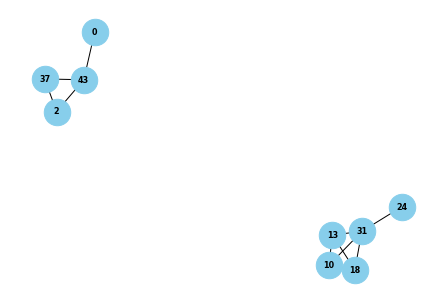

{(0, 43): 16011.18979, (0, 42): 29832.45227, (0, 41): 34130.609288, (0, 40): 39610.193432, (0, 38): 43246.561147, (0, 39): 44815.590338, (0, 35): 49574.269353, (43, 42): 13821.26248, (43, 41): 18119.419498, (43, 40): 23599.003642, (43, 38): 27235.371357, (43, 39): 28804.400548, (43, 35): 33563.079563, (43, 36): 35805.933658, (43, 37): 36795.4581417, (43, 1): 42846.9603267, (43, 2): 49871.7452367, (42, 41): 4298.157018, (42, 40): 9777.741162, (42, 38): 13414.108877, (42, 39): 14983.138068, (42, 35): 19741.817083, (42, 36): 21984.671178, (42, 37): 22974.1956617, (42, 1): 29025.6978467, (42, 2): 36050.4827567, (42, 3): 48238.99729670001, (41, 40): 5479.584144, (41, 38): 9115.951859, (41, 39): 10684.98105, (41, 35): 15443.660065, (41, 36): 17686.51416, (41, 37): 18676.038643699998, (41, 1): 24727.5408287, (41, 2): 31752.325738699998, (41, 3): 43940.840278699994, (40, 38): 3636.367715, (40, 39): 5205.396906, (40, 35): 9964.075921, (40, 36): 12206.930016, (40, 37): 13196.454499700001, (40, 1

In [30]:
import networkx as nx
import matplotlib.pyplot as plt

# Assuming nodes are represented by binary variables x[i] in your model
selected_nodes = [i for i in range(len(x)) if x[i].x >= 0.99]

# Create a graph
G = nx.Graph()

# Add selected nodes to the graph
G.add_nodes_from(selected_nodes)

# Iterate over valid arcs and add edges to the graph
for i, j in valid_arcs.keys():
    if i in selected_nodes and j in selected_nodes:
        G.add_edge(i, j)

# Draw the graph
pos = nx.spring_layout(G)  # You can use different layout algorithms
nx.draw(G, pos, with_labels=True, font_weight='bold', node_color='skyblue', node_size=700, font_size=8)
plt.show()


print(valid_arcs)
c = [nodes_data.loc[i, 'Cost_of_installation [euro]'] for i in selected_nodes]
t = 0
for i in c:
  t += i
print(t)

print(f"distance 42 to 1 {valid_arcs[42, 1]}")
sum_cost = 0
for i in nodes_data.index:
  sum_cost +=  nodes_data.loc[i, 'Cost_of_installation [euro]']

print(sum_cost)

print(distance_matrix[42, 41] + distance_matrix[41, 40] +
      distance_matrix[40, 38] + distance_matrix[38, 39] +
      distance_matrix[39, 35] + distance_matrix[35, 36] +
      distance_matrix[36, 37] + distance_matrix[37, 1])
print(distance_matrix)
# print(distance_matrix[42 -> 41 -> 40 -> 38 -> 39 -> 35 -> 36 -> 37 -> 1])